 - ww-conflict 이라고도 하는 Lost Update는 동시 트랜잭션이 동일한 행을 업데이트할 때 발생하는 이상 현상이며 REPEATABLE READ 및 SERIALIZABLE 수준에서 모두 방지해야 함. (READ COMMITTED 수준은 업데이트 손실을 방지할 필요가 없습니다.)
 - 이 섹션에서는 PostgreSQL이 업데이트 손실을 방지하는 방법을 설명하고 예제를 보여줌.

**Behavior of Concurrent UPDATE Commands**

- UPDATE 명령이 실행되면 ExecUpdate 함수가 내부적으로 호출

**ExecUpdate의 의사코드**



```
(1)   FOR each row that will be updated by this UPDATE command
(2)        WHILE true

                /*
                 * The First Block
                 */
(3)             IF the target row is 'being updated' THEN
(4)	             WAIT for the termination of the transaction that updated the target row

(5)                  IF (the status of the terminated transaction is COMMITTED)
   	               AND (the isolation level of this transaction is REPEATABLE READ or SERIALIZABLE) THEN
(6)	                  ABORT this transaction  /* First-Updater-Win */
                     ELSE
(7)                       GOTO step (2)
                     END IF

                /*
                 * The Second Block
                 */
(8)             ELSE IF the target row has been updated by another concurrent transaction THEN
(9)                  IF (the isolation level of this transaction is READ COMMITTED THEN
(10)                      UPDATE the target row
                     ELSE
(11)                      ABORT this transaction  /* First-Updater-Win */
                     END IF

                /*
                 * The Third Block
                 */
                ELSE  /* The target row is not yet modified               */
                      /* or has been updated by a terminated transaction. */
(12)                  UPDATE the target row
                END IF
           END WHILE
      END FOR
```

(1) 이 UPDATE 명령으로 업데이트될 각 행을 가져옴.

(2) 대상 행이 업데이트될 때까지(또는 이 트랜잭션이 중단될 때까지) 다음 프로세스를 반복.

(3) 대상 행이 업데이트되는 경우 (3)단계로 이동.
  - 그렇지 않으면 단계 (8)로 이동.

(4) PostgreSQL은 SI에서 first-updater-win 방식을 사용하므로 대상 행을 업데이트한 트랜잭션이 종료될 때까지 기다림 .

(5) 대상 행을 업데이트한 트랜잭션의 상태가 COMMITTED이고 해당 트랜잭션의 격리 수준이 REPEATABLE READ(또는 SERIALIZABLE)인 경우 (6)단계로 이동.
  - 그렇지 않으면 단계 (7)로 이동.

(6) 업데이트 손실을 방지하려면 이 transaction을 중단.

(7) (2)단계로 이동하여 다음 라운드에서 대상 행 업데이트를 시도.

(8) 다른 동시 트랜잭션에 의해 대상 행이 업데이트된 경우 (9)단계로 이동.
  - 그렇지 않으면 단계 (12)로 이동.

(9) 이 트랜잭션의 격리 수준이 READ COMMITTED인 경우 단계(10)으로 이동.
  - 그렇지 않으면 단계 (11)로 이동.

(10) 대상 행을 업데이트하고 (1)단계로 이동.

(11) 업데이트 손실을 방지하려면 이 transaction을 중단.

(12) 대상 행을 업데이트하고 (1)단계로 이동.
  - 대상 행이 아직 수정되지 않았거나 종료된 트랜잭션에 의해 업데이트되었기 때문. 즉, ww-conflict이 있음

- 이 함수는 각 대상 행에 대해 업데이트 작업을 수행합니다.
- 각 행을 업데이트하는 while 루프가 있으며, while 루프 내부는 그림의 조건에 따라 3개의 블록으로 분기


**ExecUpdate의 세 가지 내부 블록.**

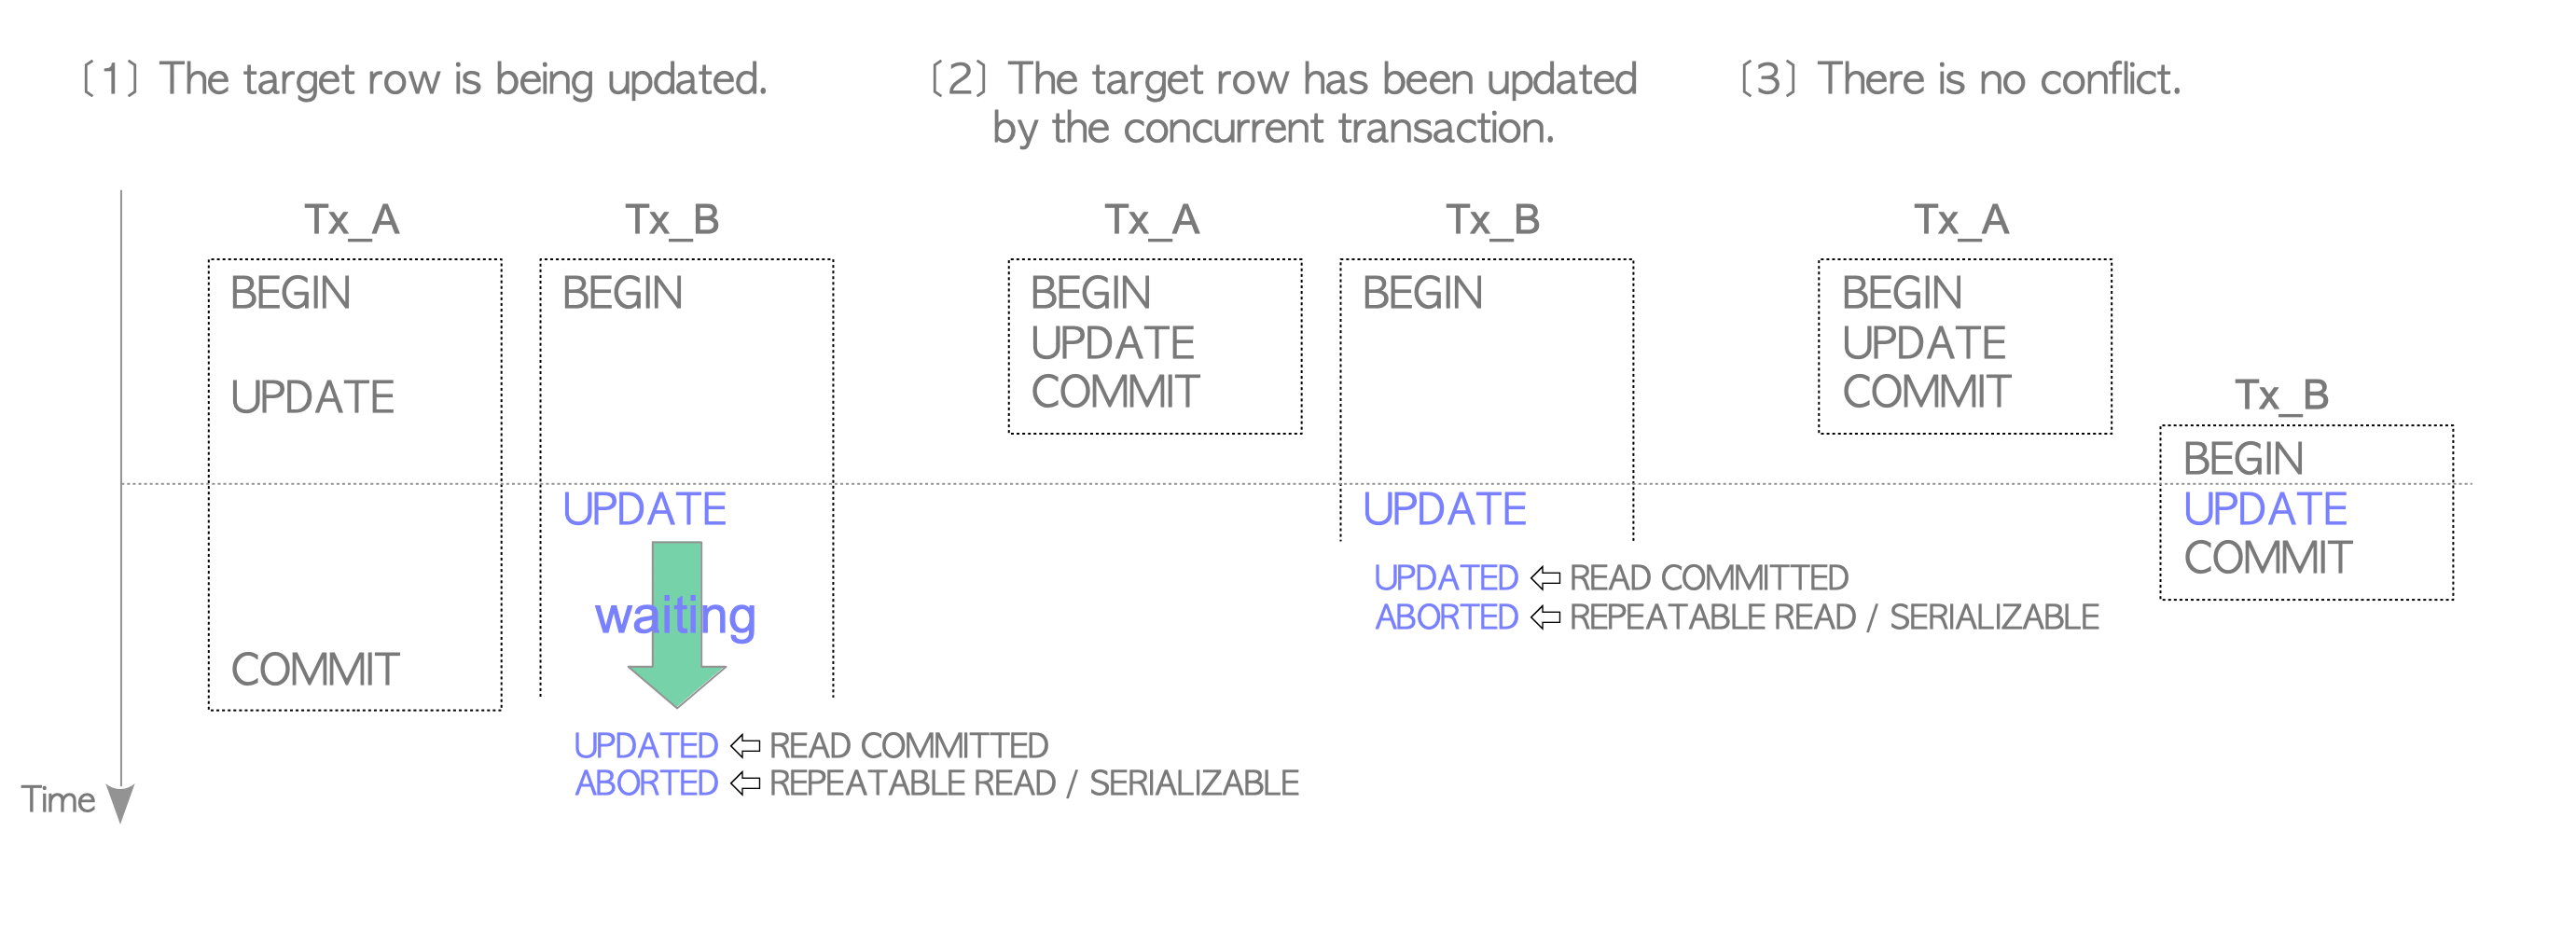

[1] 대상 행이 업데이트 중.

- '업데이트 중'은 해당 행이 다른 동시 트랜잭션에 의해 업데이트 중이며 해당 트랜잭션이 종료되지 않았음을 의미.
- 이 경우 PostgreSQL의 SI는 first-updater-win 방식을 사용하므로 현재 트랜잭션은 대상 행을 업데이트한 트랜잭션이 종료될 때까지 기다려야 함.
  - 예를 들어, 트랜잭션 Tx_A 및 Tx_B가 동시에 실행되고 Tx_B가 행 업데이트를 시도한다고 가정. 그러나 Tx_A는 이를 업데이트했으며 아직 진행 중.
  - 이 경우 Tx_B는 Tx_A의 종료를 기다림.
  - 대상 행을 업데이트한 트랜잭션이 커밋된 후 현재 트랜잭션의 업데이트 작업이 진행됨.
  - 현재 트랜잭션이 READ COMMITTED 수준에 있으면 대상 행이 업데이트됨.
  - 그렇지 않으면(REPEATABLE READ 또는 SERIALIZABLE) 업데이트 손실을 방지하기 위해 현재 트랜잭션이 즉시 중단됨.

<br>

[2] 동시 트랜잭션에 의해 대상 행이 업데이트되었음.

- 현재 트랜잭션이 대상 튜플을 업데이트하려고 시도.
- 그러나 다른 동시 트랜잭션은 대상 행을 업데이트했으며 이미 커밋되었음.
- 이 경우 현재 트랜잭션이 READ COMMITTED 수준에 있으면 대상 행이 업데이트됨.
- 그렇지 않으면 업데이트 손실을 방지하기 위해 현재 트랜잭션이 즉시 중단됨.

<br>

[3] 충돌이 없음.

- 충돌이 없으면 현재 트랜잭션이 대상 행을 업데이트할 수 있음.

<br>

**First-updater-win / First-commiter-win**

- 이 섹션에서 언급했듯이 SI 기반 PostgreSQL의 동시성 제어는 업데이트 손실을 방지하기 위해 first-updater-win 방식을 사용.
- 대조적으로, PostgreSQL의 SSI는 직렬화 이상 현상을 피하기 위해 첫 번째 커미터 승리 방식을 사용.

**Examples**

- 첫 번째 및 두 번째 예는 대상 행이 업데이트될 때의 동작을 보여주고, 세 번째 예는 대상 행이 업데이트될 때의 동작을 보여줌.

**Example 1**

- 트랜잭션 Tx_A 및 Tx_B는 동일한 테이블의 동일한 행을 업데이트하며 해당 격리 수준은 READ COMMITTED


```
testdb=# -- Tx_A
testdb=# START TRANSACTION
testdb-#    ISOLATION LEVEL READ COMMITTED;
START TRANSACTION


testdb=# UPDATE tbl SET name = 'Hyde';
UPDATE 1





testdb=# COMMIT;
COMMIT
testdb=#
testdb=# -- Tx_B
testdb=# START TRANSACTION
testdb-#    ISOLATION LEVEL READ COMMITTED;
START TRANSACTION


testdb=# UPDATE tbl SET name = 'Utterson';


(this transaction is being blocked)


UPDATE 1
```

- Tx_B는 다음과 같이 실행.

- UPDATE 명령을 실행한 후 Tx_B는 Tx_A가 종료될 때까지 기다려야 함.
- 왜냐하면 대상 튜플이 Tx_A에 의해 업데이트되고 있기 때문(ExecUpdate의 (4)단계).

- Tx_A가 커밋된 후 Tx_B는 대상 행 업데이트를 시도(ExecUpdate의 단계 (7)).

- ExecUpdate의 두 번째 라운드에서는 대상 행이 Tx_B에 의해 다시 업데이트(ExecUpdate의 (2),(8),(9),(10)단계).

**Example 2**

- Tx_A와 Tx_B는 동일한 테이블에서 동일한 행을 업데이트하며 격리 수준은 각각 READ COMMITTED 및 REPEATABLE READ


```
testdb=# -- Tx_A
testdb=# START TRANSACTION
testdb-#    ISOLATION LEVEL READ COMMITTED;
START TRANSACTION


testdb=# UPDATE tbl SET name = 'Hyde';
UPDATE 1





testdb=# COMMIT;
COMMIT
testdb=#
testdb=# -- Tx_B
testdb=# START TRANSACTION
testdb-#    ISOLATION LEVEL REPEATABLE READ;
START TRANSACTION


testdb=# UPDATE tbl SET name = 'Utterson';


(this transaction is being blocked)


ERROR:couldn't serialize access due to concurrent update
```

- Tx_B의 동작은 다음과 같이 실행.

- UPDATE 명령을 실행한 후 Tx_B는 Tx_A가 종료될 때까지 기다려야 함(ExecUpdate의 (4)단계).

- Tx_A가 커밋된 후 대상 행이 업데이트되고 이 트랜잭션의 격리 수준이 REPEATABLE READ(ExeUpdate의 (5) 및 (6)단계)이기 때문에 충돌을 해결하기 위해 Tx_B가 중단

**Example 3**

- Tx_B(REPEATABLE READ)는 커밋된 Tx_A에 의해 업데이트된 대상 행을 업데이트하려고 시도
- 이 경우 Tx_B는 중단(ExecUpdate의 (2),(8),(9),(11)단계).



```
testdb=# -- Tx_A
testdb=# START TRANSACTION
testdb-#    ISOLATION LEVEL READ COMMITTED;
START TRANSACTION


testdb=# UPDATE tbl SET name = 'Hyde';
UPDATE 1

testdb=# COMMIT;
COMMIT
testdb=#
testdb=#
testdb=# -- Tx_B
testdb=# START TRANSACTION
testdb-#    ISOLATION LEVEL REPEATABLE READ;
START TRANSACTION
testdb=# SELECT * FROM tbl;
  name  
--------
 Jekyll
(1 row)
testdb=# UPDATE tbl SET name = 'Utterson';
ERROR:couldn't serialize access due to concurrent update
```

